https://mcatalano26.github.io/Data-Science-Final-Project/

https://github.com/mcatalano26/Data-Science-Final-Project

The first link is a link to the github.io site. The second link is to the github page where you can easily find all of our data.

# Final Tutorial: The Happiness Project

## Intro
This project is a collaboration between Matt Catalano and Eli Mendels for our Data Science class with Nick Mattei. We will be examining what metrics correspond to national happiness and then trying to predict which counties in the US will be the happiest.

## Housekeeping Stuff

In [1]:
#pip install geopandas

In [2]:
#pip install descartes

In [3]:
#pip install PyShp

In [4]:
#Importing all the necesary libraries. 
import sqlite3
import pandas as pd

import geopandas as geo
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import re
import seaborn as sns
import sklearn
from sklearn import linear_model
import random
import shapefile

#The below is for formatting and taken from past labs written by Nick Mattei
#This lets us show plots inline and also save PDF plots if we want them
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
matplotlib.style.use('fivethirtyeight')

# These two things are for Pandas, it widens the notebook and lets us display data easily.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Show all the rows of a dataframe
pd.options.display.max_rows = 10000
pd.options.display.width = 1000

## Examining the Country Data
In looking at the country data, the first step is to read it into a dataframe. Once the data has been read, we will clean it to prepare it for analysis and add any other data that we deem important. Finally, once it is in an easy to manipulate form we will do some simple exploratory analysis of the final dataframe.

### Reading in the Data

### World Factbook Data

Most of our country data will come from the CIA world factbook. We got the data in csv format from https://github.com/thewiremonkey/factbook.csv. 
The data is formatted in a collection of spreadsheets each of which contains three columns: an rank, the name, and the value. Each spreadsheet contains one measurement, for example population, so they must be iterated over and then each spreadsheet must be joined on name to the cumulative table.

Information about the dataset is found in the categories csv which gives a code and names the measurement for each spreadsheet. This is what will be iterated over to generate the factbook dataframe.

In [5]:
#Reading in a summary of the csv files
categories_df = pd.read_csv('categories.csv')
categories_df.head()

,Num,Category,Name
0,2147,Geography,Area
1,2119,People and Society,Population
2,2002,People and Society,Population growth rate
3,2054,People and Society,Birth rate
4,2066,People and Society,Death rate


In [6]:
#A string to store part of the file names
csv_string = 'WorldFactBookData/c'
#Temporary dataframe to store csvs that need to be added to the dataframe. 
#It's used here to ge the names of each country
df_to_add = pd.read_csv('WorldFactBookData/c2147.csv')
#Creating the dataframe with just the names
factbook_df = pd.DataFrame({'Name' : df_to_add['Name']})


In [7]:
#Iterating through each file code in the categories list and adding the csv to the dataframe
for index, row in categories_df.iterrows():
    file_name = csv_string  + str(row['Num']) + '.csv'
    df_to_add = pd.read_csv(file_name)
    df_to_add = df_to_add.drop(columns=['Pos'])
    column_name = row['Name']
    df_to_add = df_to_add.rename(columns={"Value": column_name})
    factbook_df = factbook_df.merge(df_to_add, how = 'left')

In [8]:
factbook_df.head()

,Name,Area,Population,Population growth rate,Birth rate,Death rate,Net migration rate,Maternal mortality rate,Infant mortality rate,Life expectancy at birth,...,Natural gas - imports,Natural gas - proved reserves,Telephones - fixed lines,Telephones - mobile cellular,Internet users,Airports,Railways,Roadways,Waterways,Military expenditures
0,Russia,17098242,1.424238e+08,-0.04,11.60,13.69,1.69,34.0,6.97,70.47,...,8.200000e+09,4.780000e+13,39430000.0,2.210000e+08,84400000.0,1218.0,87157.0,1283387.0,102000.0,3.49
1,Canada,9984670,3.509984e+07,0.75,10.28,8.42,5.66,12.0,4.65,81.76,...,2.670000e+10,1.889000e+12,16600000.0,2.950000e+07,32400000.0,1467.0,46552.0,1042300.0,636.0,1.24
2,United States,9826675,3.213689e+08,0.78,12.49,8.15,3.86,21.0,5.87,79.68,...,8.163000e+10,8.734000e+12,129400000.0,3.174000e+08,276600000.0,13513.0,224792.0,6586610.0,41009.0,4.35
3,China,9596960,1.367485e+09,0.45,12.49,7.53,-0.44,37.0,12.44,75.41,...,5.190000e+10,3.300000e+12,249400000.0,1.300000e+09,626600000.0,507.0,86000.0,4106387.0,110000.0,1.99
4,Brazil,8514877,2.042598e+08,0.77,14.46,6.58,-0.14,56.0,18.60,73.53,...,1.385000e+10,3.887000e+11,44100000.0,2.807000e+08,108200000.0,4093.0,28538.0,1580964.0,50000.0,1.47


### Happiness Data

Now that we have a dataframe that stores our data about each country, it's time to look at the results of the happiness survey for each country. This process is fairly easy because it is already in one csv file ready to go.

In [9]:
happiness_df = pd.read_csv('2015.csv')

In [10]:
happiness_df.head()

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201
2,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204
3,Norway,Western Europe,4,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531
4,Canada,North America,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176


## Combining the Country Data

The next step is to combine the two data sets with country data. This will be done with a simple left join on the happiness dataframe because we are only interested in the countries that have a happiness score. 

The first thing we will do is find out which countries are in the happiness survey but not the world factbook. Once that is done, decisions will be made on a case by case basis to determine whether the data needs to be manipulated for the join to work or if those specific rows need to be dropped. Since some countries go by different names in the two different datasets, it is likely that some names will need to be changed in one data set so that the primary keys match up.

In [11]:
#An initial merge to find which countries names need to be manually changed for the match. 
#Since there are only 8 countries they will be addressed manually
prelim_merge = happiness_df.merge(factbook_df, how = 'left', left_on = 'Country', right_on = 'Name')
countries_to_match = prelim_merge[prelim_merge['Area'].isnull()]
countries_to_match

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),...,Natural gas - imports,Natural gas - proved reserves,Telephones - fixed lines,Telephones - mobile cellular,Internet users,Airports,Railways,Roadways,Waterways,Military expenditures
46,South Korea,Eastern Asia,47,5.984,0.04098,1.24461,0.95774,0.96538,0.33208,0.07857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,North Cyprus,Western Europe,66,5.695,0.05635,1.20806,1.07008,0.92356,0.49027,0.14280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90,Somaliland region,Sub-Saharan Africa,91,5.057,0.06161,0.18847,0.95152,0.43873,0.46582,0.39928,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,Palestinian Territories,Middle East and Northern Africa,108,4.715,0.04394,0.59867,0.92558,0.66015,0.24499,0.12905,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119,Congo (Kinshasa),Sub-Saharan Africa,120,4.517,0.03680,0.00000,1.00120,0.09806,0.22605,0.07625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128,Myanmar,Southeastern Asia,129,4.307,0.04351,0.27108,0.70905,0.48246,0.44017,0.19034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138,Congo (Brazzaville),Sub-Saharan Africa,139,3.989,0.06682,0.67866,0.66290,0.31051,0.41466,0.11686,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150,Ivory Coast,Sub-Saharan Africa,151,3.655,0.05141,0.46534,0.77115,0.15185,0.46866,0.17922,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The countries that are recognized in both dataframes are renamed below and the countries not universally recognized will be dropped. This is the first major decision we will make with regards to missing data. In the end we decided to not look at North Cyprus, Somaliland, or Palestine as these regions are contested and not widely recognized.

In [12]:
#Renaming Korea, South to South Korea in the factbook_df
factbook_df.at[108, 'Name'] = 'South Korea'
#Renaming Burma to Myanmar in the factbook_df
factbook_df.at[39, 'Name'] = 'Myanmar'
#Renaming Cote d'Ivoire to Ivory Coast in the factbook_df
factbook_df.at[68, 'Name'] = 'Ivory Coast'
#Renaming Congo, Republic of the to Congo (Brazzaville) in the factbook_df
factbook_df.at[63, 'Name'] = 'Congo (Brazzaville)'
#Renaming Congo, Democratic Republic of the to Congo (Kinshasa) in the factbook_df
factbook_df.at[10, 'Name'] = 'Congo (Kinshasa)'

In [13]:
#Creating a final dataframe to store all of our country data
countries_df = happiness_df.merge(factbook_df, how = 'left', left_on = 'Country', right_on = 'Name')

In [14]:
countries_df.head()

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),...,Natural gas - imports,Natural gas - proved reserves,Telephones - fixed lines,Telephones - mobile cellular,Internet users,Airports,Railways,Roadways,Waterways,Military expenditures
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,...,3.764000e+09,0.000000e+00,4370000.0,11500000.0,7100000.0,63.0,4876.0,71464.0,1292.0,0.76
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,...,0.000000e+00,0.000000e+00,170000.0,370000.0,316400.0,96.0,NaN,12890.0,NaN,0.13
2,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,...,1.363000e+09,4.301000e+10,1880000.0,7100000.0,5400000.0,80.0,2667.0,73929.0,400.0,1.41
3,Norway,Western Europe,4,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,...,2.000000e+06,2.090000e+12,1160000.0,5900000.0,4900000.0,95.0,4237.0,93870.0,1577.0,1.40
4,Canada,North America,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,...,2.670000e+10,1.889000e+12,16600000.0,29500000.0,32400000.0,1467.0,46552.0,1042300.0,636.0,1.24


## Cleaning the Country Data

Now that we have the country dataframe it is time to clean it. This means dropping any unnecesary columns, ensuring each column is of the right type, and performing operations on some columns to make them better suited for maniuplation

The first step will be to remove all the columns that we won't be looking at. We will start by removing the columns that came with the happiness data as they were already selected as indicators of happiness and could not exist on a county level. Then, we will remove a variety of other columns that we know won't exist at a county level. Note that not all such columns are removed mostly ones having to do with national finances.

In [15]:
#Creating a list of columns to be removed
columns_to_be_removed = ['Reserves of foreign exchange and gold', 
                         'Standard Error', 'Dystopia Residual', 'Generosity', 'Trust (Government Corruption)', 'Area', 'Gross national saving', 
                         'Inflation rate (consumer prices)', 'Central bank discount rate', 
                         'Commercial bank prime lending rate', 'Stock of narrow money', 
                         'Stock of broad money', 'Stock of domestic credit', 
                         'Market value of publicly traded shares', 'Current account balance', 
                         'Stock of direct foreign investment - at home', 
                         'Stock of direct foreign investment - abroad','Economy (GDP per Capita)',
                         'Family', 'Health (Life Expectancy)', 'Freedom','Name','Railways', 'Waterways']
countries_df = countries_df.drop(columns_to_be_removed, axis = 1)

Once those columns are dropped, we will make sure each column is of the correct dtype. To do this, we will use the pd.DataFrame.dtypes method to look at the dypes of each column and determine which columns are not correct. We will then convert them to the correct once. In this case this involves removing dollar signs and commas from numbers then converting to float64s.

In [16]:
#Creating a list of all the columns with a leading dollar sign that need to be converted to int64
object_cols = ['GDP (purchasing power parity)','GDP - per capita (PPP)','Exports', 'Imports', 'Debt - external']
#Iterating through the list, removing any non numereical symbols and then casting as float64
for i in object_cols:
    #Using a (poorly executed) Regex fucntion to convert to a number
    countries_df[i] = countries_df[i].str.replace(',', "")
    countries_df[i] = countries_df[i].str.replace('$', "")
    
    countries_df[i] = countries_df[i].astype('float64')

The next data conversion that needs to be done is converting gross metrics into per capita metrics. This is done by creating a list of all the gross metrics, iterating over them to create a column with the per capita version of the metric, and then removing the redundant gross metric column.

In [17]:
gross_measurements = ['Health expenditures', "HIV/AIDS - people living with HIV/AIDS", "HIV/AIDS - deaths",
                           'Children under the age of 5 years underweight', "Education expenditures",
                           'Telephones - fixed lines', 'Telephones - mobile cellular', "Internet users",
                           'Military expenditures', 'Labor force',  'Public debt', 'Electricity - production', 
                           'Electricity - consumption','Electricity - exports', 'Electricity - imports',
                           'Electricity - installed generating capacity', 'Electricity - from fossil fuels',
                           'Electricity - from nuclear fuels','Electricity - from hydroelectric plants',
                           'Electricity - from other renewable sources',"Airports","Roadways"]
for i in gross_measurements:
    countries_df[i + ' per capita'] = countries_df[i] / countries_df["Population"]
    countries_df = countries_df.drop([i], axis=1)

Now that we have a clean dataset we will create a standardized version of it. This will allow us to compare across data sets which will be necesary when we start to look at the county data. It is easy to standardize a dataframe of only numerical data so I will extract the string columns, standardize the numerical dataframe and then add the string columns back.

In [18]:
#Creating the numerical dataframe
numerical_country_df = countries_df.drop(['Country', 'Region'], axis = 1)
#Standardizing it
standardized_country_df = (numerical_country_df-numerical_country_df.mean())/numerical_country_df.std()
#Adding back the names and countries
standardized_country_df.insert(0, 'Region', countries_df['Region'])
standardized_country_df.insert(0, 'Country', countries_df['Country'])
standardized_country_df.columns.values

array(['Country', 'Region', 'Happiness Rank', 'Happiness Score',
       'Population', 'Population growth rate', 'Birth rate', 'Death rate',
       'Net migration rate', 'Maternal mortality rate',
       'Infant mortality rate', 'Life expectancy at birth',
       'Total fertility rate', 'HIV/AIDS - adult prevalence rate',
       'Obesity - adult prevalence rate',
       'Unemployment, youth ages 15-24', 'GDP (purchasing power parity)',
       'GDP - real growth rate', 'GDP - per capita (PPP)',
       'Industrial production growth rate', 'Unemployment rate',
       'Distribution of family income - Gini index',
       'Taxes and other revenues', 'Budget surplus (+) or deficit (-)',
       'Exports', 'Imports', 'Debt - external', 'Crude oil - production',
       'Crude oil - exports', 'Crude oil - imports',
       'Crude oil - proved reserves',
       'Refined petroleum products - production',
       'Refined petroleum products - consumption',
       'Refined petroleum products - exports',

# Exploratory Analysis of the Country Data

With the cleaned and organized data we can finally start to look at what it says. This will be done in a couple ways. The first will be to look at the distribution of happiness. Then we will begin to look at what variables correlate to happiness.

To look at the distribution of happiness, we will use both a box plot and a histogram.

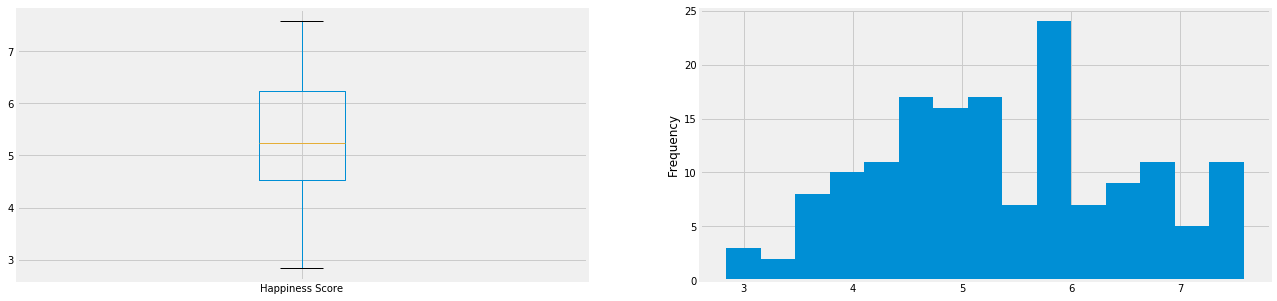

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
countries_df['Happiness Score'].plot.box(ax = ax[0])
countries_df['Happiness Score'].plot.hist(bins = 15, ax = ax[1])

From these graphs, it's clear that the happiness scores follow a somewhat normal distribution. The mean value is about 5.2 with a range of 2.8 to 7.8. There doesn't appear to be much of a skew and there are not many outliers. 

Below, we will begin to look at which variables relate to the happiness score for each country. 

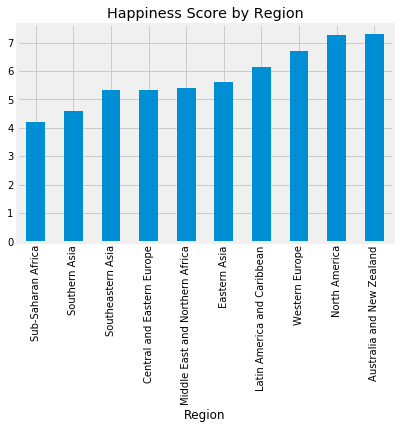

In [20]:
countries_df.groupby('Region')['Happiness Score'].mean().sort_values().plot.bar(title = 'Happiness Score by Region')

It's clear that there is a relationship between region and mean happiness score. The happiest regions also happen to be the wealthies regions, a relationship that will become more obvious as we do more analysis. 

Below, I take a look at the correlation between each variable and happiness, then select the ones with high correlation values. Since a correlation can be negative I look at large positive or negative correlation values and then plot them below to show which variables have the strongest correlation.

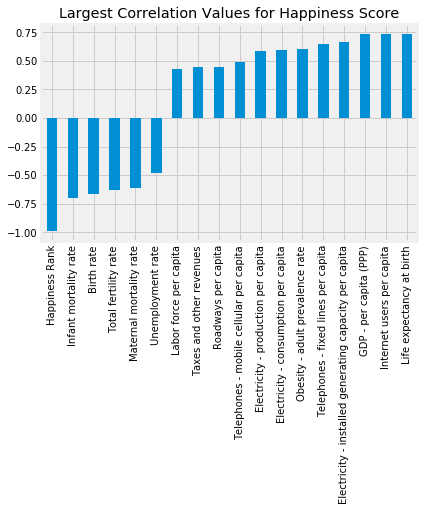

In [21]:
happiness_corr_df = countries_df.corr()
happiness_corr_df = happiness_corr_df[(happiness_corr_df['Happiness Score'] >= .4) | (happiness_corr_df['Happiness Score'] <= -.4)]["Happiness Score"]
happiness_corr_df = happiness_corr_df.drop('Happiness Score')
happiness_corr_df = happiness_corr_df.sort_values()
happiness_corr_df.plot.bar(title = 'Largest Correlation Values for Happiness Score')


In [22]:
countries_df.corr()['Happiness Score'].head()

Happiness Rank           -0.992105
Happiness Score           1.000000
Population               -0.022815
Population growth rate   -0.394130
Birth rate               -0.664718
Name: Happiness Score, dtype: float64

As seen in the graph, the variables that correlate the most with happiness are ones based largely on health and wealth. This is a realtionship we will look at much more in depth when we begin to compare the country and county datasets. Internet and electricity use are somewhat suprising because, while they do correlate with wealth there are other metrics, such as children under the age of 5 underweight, that we thought would correlate more with happiness. 

In [23]:
world_map_df = geo.read_file('Countries_WGS84.shp')
world_map_key_df = pd.read_csv('Countries_WGS84.csv')
world_map_df = world_map_df.merge(world_map_key_df, how = 'left', left_index = True, right_index = True )
world_map_df.head()

,geometry,OBJECTID,CNTRY_NAME
0,"POLYGON ((-69.88223 12.41111, -69.94695 12.436...",1,Aruba
1,"MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ...",2,Antigua and Barbuda
2,"POLYGON ((61.27656 35.60725, 61.29638 35.62853...",3,Afghanistan
3,"POLYGON ((-5.15213 30.18047, -5.13917 30.19236...",4,Algeria
4,"MULTIPOLYGON (((45.02583 41.03055, 45.00999 41...",5,Azerbaijan


In [24]:
#Countries to rename
world_map_df.at[25, 'Name'] = 'Myanmar'
world_map_df.at[27, 'Name'] = 'Belarus'
#Adding greenland as part of denmark
world_map_df.at[86, 'Name'] = 'Denmark'

#Congo at 39 what do?

In [25]:
world_map_df = world_map_df.merge(countries_df, left_on = 'CNTRY_NAME', right_on = 'Country', how = 'left')


/opt/conda/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


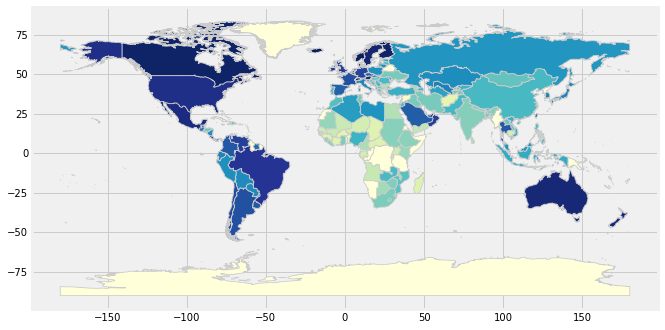

In [154]:
# set the range for the choropleth
vmin, vmax = 120, 220
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))
world_map_df.plot(column='Happiness Score', cmap='YlGnBu', linewidth=0.8, ax=ax, edgecolor = '0.8' )

## County Data

There is a lot of county data that we need and we will start loading and tidying csv files here. We will only use data from the most recent year we can find and then standardize the data over the year so we can compare the most recent data to the standardized 2015 data from the world factbook. First, we will load in a dataset that contains population estimates for counties.

In [27]:
state_pop_df = pd.read_csv('PopulationEstimates.csv')
state_pop_df.head()

,FIPS,State,Area_Name,Census Pop 2010,Estimates Base 2010,Pop Estimate 2010,Pop Estimate 2011,Pop Estimate 2012,Pop Estimate 2013,Pop Estimate 2014,...,Natural increase rate 2017,Natural increase rate 2018,Net migration rate 2011,Net migration rate 2012,Net migration rate 2013,Net migration rate 2014,Net migration rate 2015,Net migration rate 2016,Net migration rate 2017,Net migration rate 2018
0,0,US,United States,"308,745,538","308,758,105","309,326,085","311,580,009","313,874,218","316,057,727","318,386,421",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000,AL,Alabama,"4,779,736","4,780,138","4,785,448","4,798,834","4,815,564","4,830,460","4,842,481",...,1.1,0.8,0.5,1.2,1.6,0.6,0.6,0.8,1.1,1.9
2,1001,AL,Autauga County,"54,571","54,574","54,754","55,208","54,936","54,713","54,876",...,2.7,2.2,6.0,-6.1,-3.9,2.0,-1.9,5.3,1.0,0.6
3,1003,AL,Baldwin County,"182,265","182,264","183,111","186,540","190,143","194,886","199,189",...,0.8,0.1,16.3,17.6,22.9,20.2,17.9,21.5,22.5,24.8
4,1005,AL,Barbour County,"27,457","27,457","27,330","27,350","27,174","26,944","26,758",...,-1.0,-2.5,0.3,-6.8,-8.1,-5.1,-15.5,-18.2,-25.0,-8.6


There are some columns that are empty due to the way that the data was loaded in. First, we will drop those columns as well as the row containing the United States data (as that is irrelevant here).

After we filter these columns, we will get rid of all data except for the most recent year.

In [28]:
state_pop_df = state_pop_df[state_pop_df.columns.drop(list(state_pop_df.filter(regex='Unnamed')))]
state_pop_df = state_pop_df.drop(0)

lst = [i + 2010 for i in range(8)]


for i in lst:
    i = str(i)
    if i=="2010":
        state_pop_df = state_pop_df.drop(['Pop Estimate ' + i], axis=1)
        state_pop_df = state_pop_df.drop(['Estimates Base ' + i], axis=1)
        state_pop_df = state_pop_df.drop(['Census Pop ' + i], axis=1)
    else:
        state_pop_df = state_pop_df.drop(['Pop Estimate ' + i], axis=1)
        state_pop_df = state_pop_df.drop(['Net migration rate '  + i], axis=1)
        state_pop_df = state_pop_df.drop(['Birth rate ' + i], axis=1)
        state_pop_df = state_pop_df.drop(['Death rate ' + i], axis=1)
        state_pop_df = state_pop_df.drop(['Natural increase rate ' + i], axis=1)

state_pop_df.head()

,FIPS,State,Area_Name,Pop Estimate 2018,Birth rate 2018,Death rate 2018,Natural increase rate 2018,Net migration rate 2018
1,1000,AL,Alabama,"4,887,871",11.7,10.9,0.8,1.9
2,1001,AL,Autauga County,"55,601",11.8,9.6,2.2,0.6
3,1003,AL,Baldwin County,"218,022",10.5,10.3,0.1,24.8
4,1005,AL,Barbour County,"24,881",10.4,12.9,-2.5,-8.6
5,1007,AL,Bibb County,"22,400",11.1,11.4,-0.3,-6.6


Now, we will look at a dataframe containing county wide unemployment data. We need to again drop the United States row as well as all of the unnamed columns. We will also remove all but the most recent data. Area_name in this data set is not initially conducive to later joins, so we will split the area name into two different columns containing the county name and the state name

In [29]:
state_unemployment_df = pd.read_csv('Unemployment.csv')
state_unemployment_df = state_unemployment_df[state_unemployment_df.columns.drop(list(state_unemployment_df.filter(regex='Unnamed')))]
state_unemployment_df = state_unemployment_df.drop(0)

lst = [i + 2007 for i in range(11)]

for i in lst:
    i = str(i)
    state_unemployment_df = state_unemployment_df.drop(['Unemployment_rate_' + i], axis=1)

state_unemployment_df[['Area_Name', 'State_Name']] = state_unemployment_df["Area_name"].str.split(", ", expand=True)
state_unemployment_df = state_unemployment_df.drop(["State", "Area_name"], axis=1)
state_unemployment_df.head()

,FIPS,Unemployment_rate_2018,Median_Household_Income_2017,Med_HH_Income_Percent_of_State_Total_2017,Area_Name,State_Name
1,1000.0,3.9,"$48,193",100.0,Alabama,None
2,1001.0,3.6,"$58,343",121.1,Autauga County,AL
3,1003.0,3.6,"$56,607",117.5,Baldwin County,AL
4,1005.0,5.2,"$32,490",67.4,Barbour County,AL
5,1007.0,4.0,"$45,795",95.0,Bibb County,AL


We will now load in a dataset that contains county wide life expectancy data. We need to, again, perform similar tasks to drop the United States row, split the location into two columns, and drop all but the most recent data.

In [30]:
county_life_exp_df = pd.read_csv('County Life Expectancy.csv')
county_life_exp_df = county_life_exp_df.drop(0)
county_life_exp_df[['Area_Name', 'State_Name']] = county_life_exp_df["Location"].str.split(", ", expand=True)
county_life_exp_df = county_life_exp_df.drop(['Location'], axis=1)

lst = [i + 1980 for i in range(7)]

c=0
for i in lst:
    i = c+i
    i = str(i)
    county_life_exp_df = county_life_exp_df.drop(['Life expectancy, ' + i], axis=1)
    c+=4
county_life_exp_df.head()

,FIPS,"Life expectancy, 2014",Area_Name,State_Name
1,1.0,"75.65 (75.57, 75.72)",Alabama,None
2,1001.0,"75.67 (75.15, 76.18)",Autauga County,Alabama
3,1003.0,"78.08 (77.72, 78.43)",Baldwin County,Alabama
4,1005.0,"75.42 (74.78, 76.07)",Barbour County,Alabama
5,1007.0,"73.97 (73.28, 74.68)",Bibb County,Alabama


Now, we can start merging the data. We will first merge the county life expectancy data with the county population data. We will merge this on the FIPS column which is a unique identifier for every county in America.

In [31]:
county_merge1_df = pd.merge(county_life_exp_df, state_pop_df, on="FIPS", how="inner")
county_merge1_df = county_merge1_df.drop(['State_Name', 'Area_Name_y'], axis=1)
county_merge1_df = county_merge1_df.rename(columns={'Area_Name_x': 'Area_Name'})
county_merge1_df.head()

,FIPS,"Life expectancy, 2014",Area_Name,State,Pop Estimate 2018,Birth rate 2018,Death rate 2018,Natural increase rate 2018,Net migration rate 2018
0,1001.0,"75.67 (75.15, 76.18)",Autauga County,AL,"55,601",11.8,9.6,2.2,0.6
1,1003.0,"78.08 (77.72, 78.43)",Baldwin County,AL,"218,022",10.5,10.3,0.1,24.8
2,1005.0,"75.42 (74.78, 76.07)",Barbour County,AL,"24,881",10.4,12.9,-2.5,-8.6
3,1007.0,"73.97 (73.28, 74.68)",Bibb County,AL,"22,400",11.1,11.4,-0.3,-6.6
4,1009.0,"76.16 (75.66, 76.69)",Blount County,AL,"57,840",11.8,11.4,0.3,0.0


We can now merge the unemployment data with the previous data and tidy it up in the same way that we tidied the previous data

In [32]:
county_merge2_df = pd.merge(county_merge1_df, state_unemployment_df, on="FIPS", how="inner")
county_merge2_df = county_merge2_df.drop(['Area_Name_y', 'State_Name'], axis=1)
county_merge2_df = county_merge2_df.rename(columns = {'Area_Name_x': 'Area_Name'})
county_merge2_df['Life expectancy, 2014'] = county_merge2_df['Life expectancy, 2014'].str[:5]
county_merge2_df.head()

,FIPS,"Life expectancy, 2014",Area_Name,State,Pop Estimate 2018,Birth rate 2018,Death rate 2018,Natural increase rate 2018,Net migration rate 2018,Unemployment_rate_2018,Median_Household_Income_2017,Med_HH_Income_Percent_of_State_Total_2017
0,1001.0,75.67,Autauga County,AL,"55,601",11.8,9.6,2.2,0.6,3.6,"$58,343",121.1
1,1003.0,78.08,Baldwin County,AL,"218,022",10.5,10.3,0.1,24.8,3.6,"$56,607",117.5
2,1005.0,75.42,Barbour County,AL,"24,881",10.4,12.9,-2.5,-8.6,5.2,"$32,490",67.4
3,1007.0,73.97,Bibb County,AL,"22,400",11.1,11.4,-0.3,-6.6,4.0,"$45,795",95.0
4,1009.0,76.16,Blount County,AL,"57,840",11.8,11.4,0.3,0.0,3.5,"$48,253",100.1


We need to turn all the columns that we want to standardize into floats with no commas or dollar signs. This will be done in the cell below

In [33]:
object_cols = ['Pop Estimate 2018','Median_Household_Income_2017', 'Life expectancy, 2014']

for i in object_cols:

    county_merge2_df[i] = county_merge2_df[i].str.replace(',', "")
    county_merge2_df[i] = county_merge2_df[i].str.replace('$', "")
    
    county_merge2_df[i] = county_merge2_df[i].astype('float64')

The following code will standardize all the numerical columns in the graph so they can be used later to compare with the country data from the world factbook. I also rename the columns here as the previous column names would no longer be accurate.

In [34]:
standardized_county_df = county_merge2_df.drop(['Area_Name', 'State', 'FIPS'], axis = 1)

standardized_county_df = (standardized_county_df-standardized_county_df.mean())/standardized_county_df.std()

standardized_county_df.insert(0, 'Area_Name', county_merge2_df['Area_Name'])
standardized_county_df.insert(0, 'State', county_merge2_df['State'])
standardized_county_df.insert(0, 'FIPS', county_merge2_df['FIPS'])

standardized_county_df = standardized_county_df.rename(columns = {"Life expectancy, 2014": "Life expectancy", "Pop Estimate 2018": "Pop Estimate", "Birth rate 2018": "Birth rate", "Death rate 2018": "Death rate", "Natural increase rate 2018": "Natural increase rate", "Net migration rate 2018": "Net migration rate", "Unemployment_rate_2018": "Unemployment rate", "Median_Household_Income_2017": "Median household income", "Med_HH_Income_Percent_of_State_Total_2017": "Median household income percent of state total"})
standardized_county_df.head()

,FIPS,State,Area_Name,Life expectancy,Pop Estimate,Birth rate,Death rate,Natural increase rate,Net migration rate,Unemployment rate,Median household income,Median household income percent of state total
0,1001.0,AL,Autauga County,-0.873113,-0.145590,0.250396,-0.284766,0.343824,-0.045029,-0.353223,0.537597,1.594697
1,1003.0,AL,Baldwin County,0.138702,0.341379,-0.266146,-0.024091,-0.173725,2.080241,-0.353223,0.409047,1.415271
2,1005.0,AL,Barbour County,-0.978073,-0.237694,-0.305880,0.944130,-0.814500,-0.852983,0.724706,-1.376808,-1.081743
3,1007.0,AL,Bibb County,-1.586841,-0.245133,-0.027742,0.385541,-0.272306,-0.677341,-0.083741,-0.391578,0.293858
4,1009.0,AL,Blount County,-0.667391,-0.138877,0.250396,0.385541,-0.124434,-0.097722,-0.420593,-0.209564,0.548045


## Some Mild Exploratory Data Analysis

There is not too much we can do with data analysis yet with just the county data (before we connect it to the happiness metric from the world factbook), but here is a little bit of data analysis to start.

If we wanted to look at how all the county data correlates with each other we could plot a heatmap of their correlation. It is interesting to me that when it is plotted it can be seen that life expectancy and median household income have a correlation of 0.65. Other than that, there are not many that are very correlated other than ones that we know should be (like median household income percent of state income to median household income).

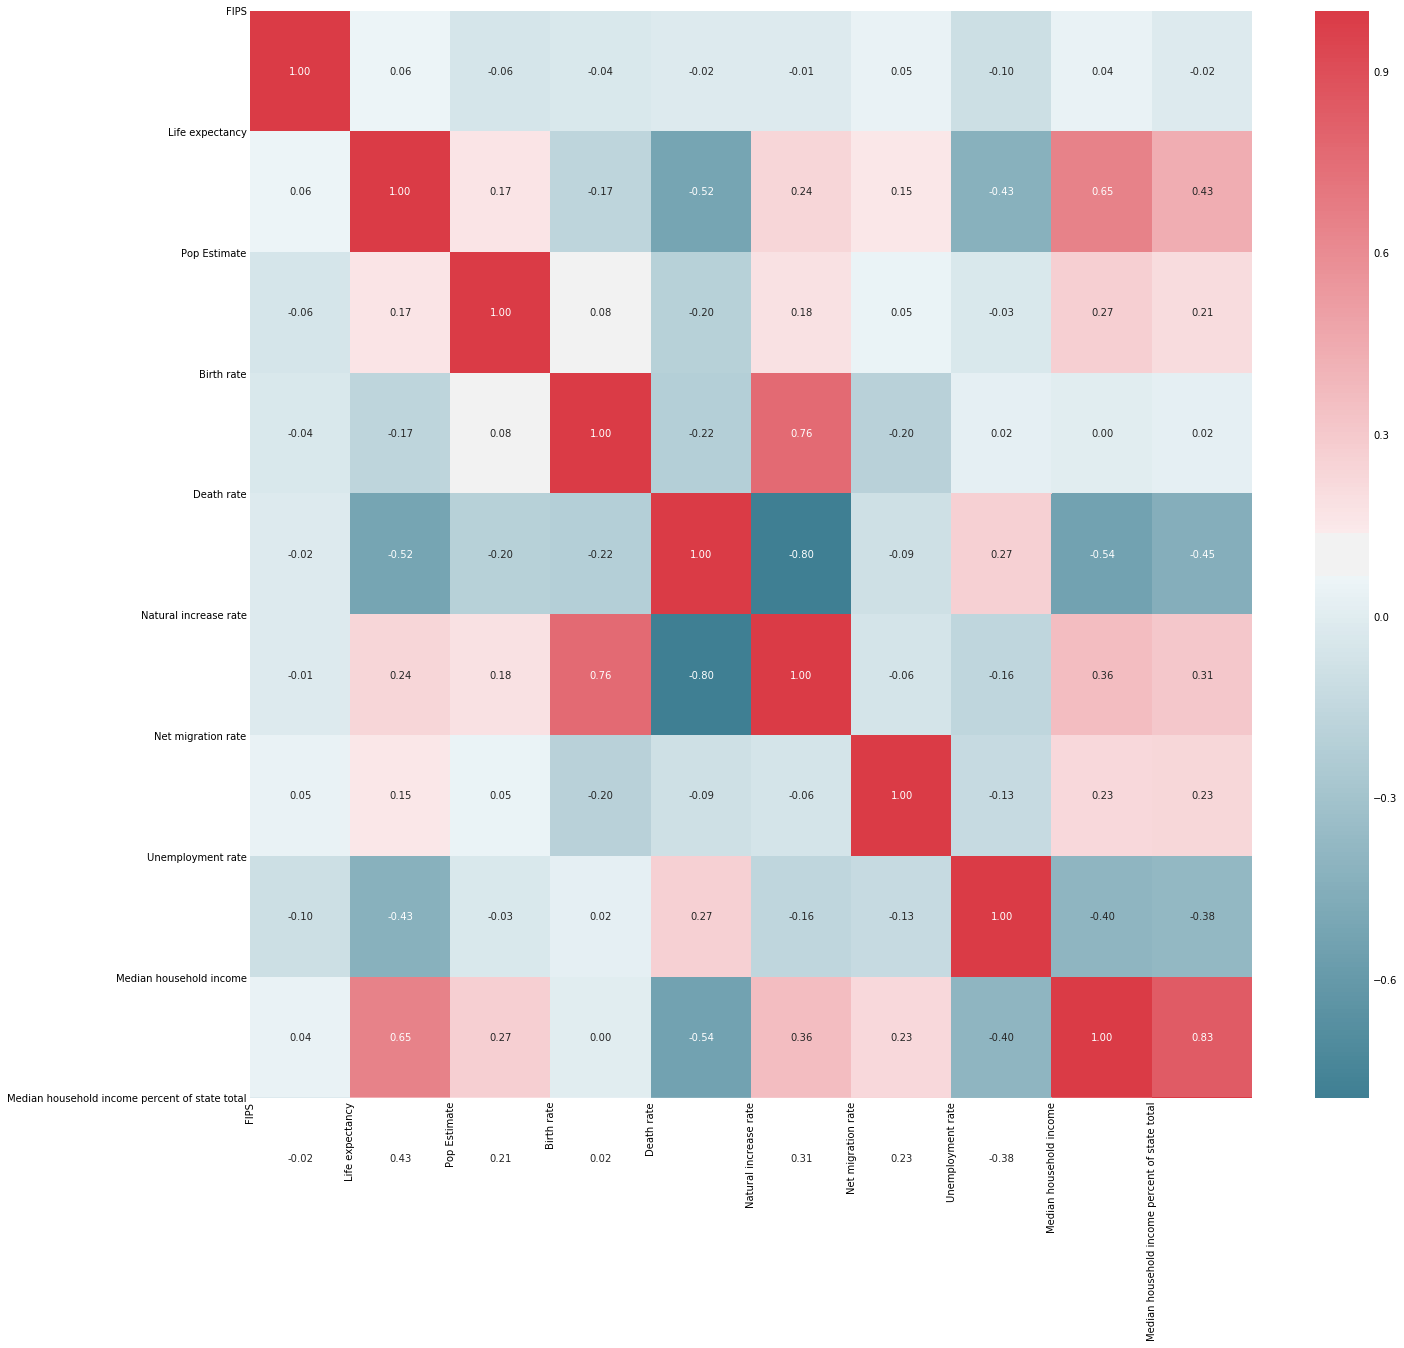

In [35]:
corr = standardized_county_df.corr()
fig, ax = plt.subplots(figsize=(20,20))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=colormap, annot=True, fmt = ".2f")
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

We can also make some bar charts with some of the more interesting data collected. Shown below is the median household income by state, life expectancy by state, and unemployment rate by state. All of this was found by finding the mean of the counties for each state.

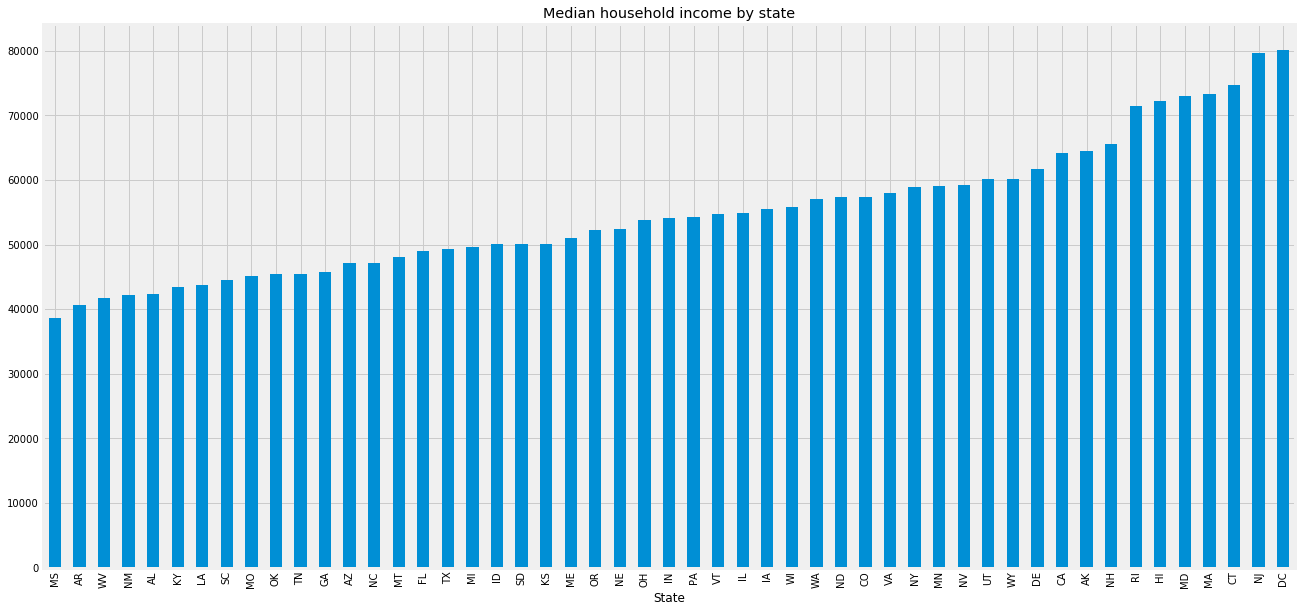

In [36]:
fig, ax = plt.subplots(figsize = (20,10))

ax1 = county_merge2_df.groupby('State')['Median_Household_Income_2017'].mean().sort_values().plot.bar(title = 'Median household income by state')

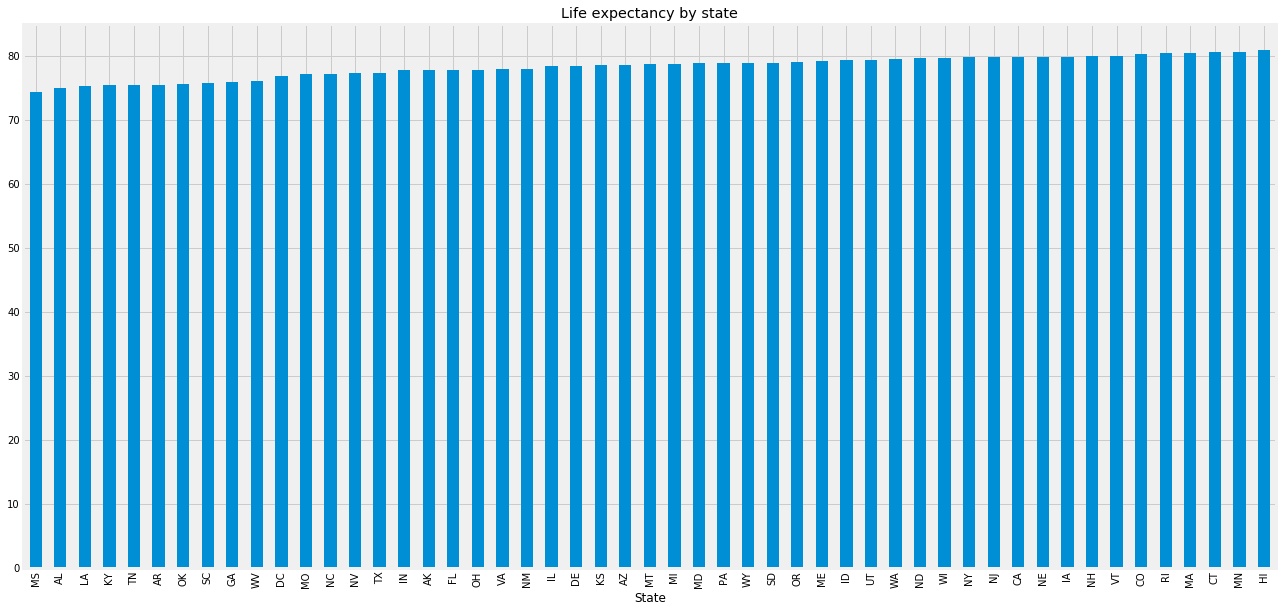

In [37]:
fig, ax = plt.subplots(figsize = (20,10))
ax2 = county_merge2_df.groupby('State')['Life expectancy, 2014'].mean().sort_values().plot.bar(title = 'Life expectancy by state')

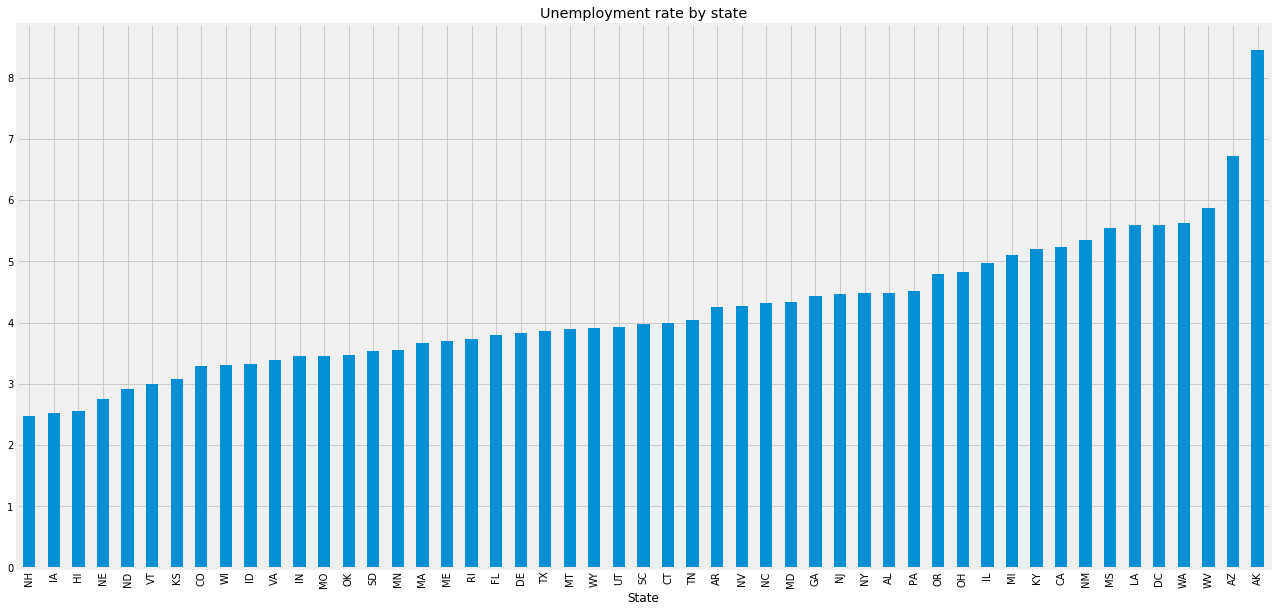

In [38]:
fig, ax = plt.subplots(figsize = (20,10))
ax2 = county_merge2_df.groupby('State')['Unemployment_rate_2018'].mean().sort_values().plot.bar(title = 'Unemployment rate by state')

It is clear that life expectancy is not very interesting at all, but household income and unemployment rate yield some more interesting figures. I find it interesting that DC is towards the top of both household income and unemployment.

### In conclusion

There are still many things to be done with this project, but we believe that this is enough work for the current milestone. 

Here is our to-do list of what still needs to be done:
 - Find more county data to be able to match with country data (such as obesity/health statistics and internet usage per county).
 - Create the happiness model using the country data correlations
 - Use the happiness model on the county dataframes to determine the happiest places in the United States.
 - Group the United States in differing geographies (such as region or state) and determine if happiness changes regionally.

In [67]:
#The relevant columns for the model
parameters = ['Happiness Score','Life expectancy at birth', 'Birth rate',
              'Death rate', 'Population', 'Unemployment rate', 'Net migration rate',
              'GDP - per capita (PPP)']
#The columns to be used as in the model
x_cols = ['Life expectancy at birth', 'Birth rate', 'Death rate',
             'Population', 'Unemployment rate', 'Net migration rate', 'GDP - per capita (PPP)']
#Creatinga a dataframe that just contains the necesary columns and DROPPING THE NA VALUES
model_df = standardized_country_df[parameters].dropna()
#Isolating the X_values and y_values
X_values = model_df[x_cols].values
y_values = model_df['Happiness Score'].values

In [136]:
#Splitting the data into training and testing data
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_values, y_values, test_size=0.1, random_state=0)

In [137]:
#generating the three models to compare: lasso, linearRegression, and ridge
#For both lasso and ridge, various values of alpha were used
linear_model = sklearn.linear_model.LinearRegression()
lasso = sklearn.linear_model.Lasso()
lasso01 = sklearn.linear_model.Lasso(alpha = .01)
lasso0001 = sklearn.linear_model.Lasso(alpha = .0001)
ridge = sklearn.linear_model.Ridge()
ridge01 = sklearn.linear_model.Ridge(alpha = .01)
ridge100 = sklearn.linear_model.Ridge(alpha = 100)

In [138]:
#Function to get the rmse of a model based on 10-fold cross val analysis
def get_rmse_10_fold(model):
    scores = sklearn.model_selection.cross_val_score(model, X_values, y_values, cv = 10, scoring="neg_mean_squared_error")
    mse = np.mean(-scores)
    rmse = np.sqrt(mse)
    return rmse

In [139]:
#Getting the rmse for each model from the 10 fold cross val testing
linear_model_rmse = get_rmse_10_fold(linear_model)
lasso_rmse = get_rmse_10_fold(lasso)
lasso01_rmse = get_rmse_10_fold(lasso01)
lasso0001_rmse = get_rmse_10_fold(lasso0001)
ridge_rmse = get_rmse_10_fold(ridge)
ridge01_rmse = get_rmse_10_fold(ridge01)
ridge100_rmse = get_rmse_10_fold(ridge100)

In [140]:
#Displaying the rmse cross_val_scores of each model
print('Linear Model RMSE: ', linear_model_rmse)
print('Lasso RMSE: ', lasso_rmse)
print('Lasso with alpha = .01 RMSE: ', lasso01_rmse)
print('Lasso with alpha = .0001 RMSE: ', lasso0001_rmse)
print('Ridge RMSE: ', ridge_rmse)
print('Ridge with alpha = .01 RMSE: ', ridge01_rmse)
print('Ridge with alpha = 100 RMSE: ', ridge100_rmse)

Linear Model RMSE:  0.7099409879787588
Lasso RMSE:  1.0381298227218954
Lasso with alpha = .01 RMSE:  0.6965341834181875
Lasso with alpha = .0001 RMSE:  0.7097443823445952
Ridge RMSE:  0.7062060178645699
Ridge with alpha = .01 RMSE:  0.709898417384035
Ridge with alpha = 100 RMSE:  0.7078364976284447


In [142]:
#Fitting the lasso model to all the countries
lasso01.fit(X_train, y_train)
y_predicted = lasso01.predict(X_test)
y_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_predicted})
y_df

,Actual,Predicted
0,1.130353,0.461424
1,1.668340,0.823565
2,0.399355,0.253029
3,-0.754346,-0.671023
4,0.540839,0.440276
5,-0.242560,0.190701
6,1.252623,0.199765
7,0.448263,-0.363371
8,0.531232,0.782357
9,1.231662,0.405193


0.5353003718846019

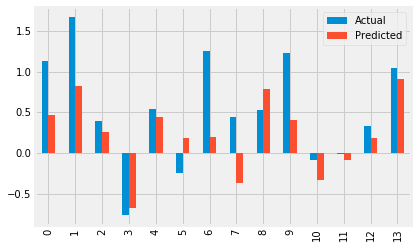

In [144]:
y_df.plot.bar()
country_rmse = np.sqrt(((y_test - y_predicted) ** 2).mean())
country_rmse

In [95]:
counties_test = standardized_county_df.rename(columns={"Life expectancy": 'Life expectancy at birth',
                                                                 'Pop Estimate': "Population",
                                                                'Median household income': 'GDP - per capita (PPP)'})

counties_test = counties_test.dropna()
counties_test['Predicted Happiness'] = lasso01.predict(counties_test[x_cols])

counties_test.head()

,FIPS,State,Area_Name,Life expectancy at birth,Population,Birth rate,Death rate,Natural increase rate,Net migration rate,Unemployment rate,GDP - per capita (PPP),Median household income percent of state total,Predicted Happiness
0,1001.0,AL,Autauga County,-0.873113,-0.145590,0.250396,-0.284766,0.343824,-0.045029,-0.353223,0.537597,1.594697,0.044851
1,1003.0,AL,Baldwin County,0.138702,0.341379,-0.266146,-0.024091,-0.173725,2.080241,-0.353223,0.409047,1.415271,0.438763
2,1005.0,AL,Barbour County,-0.978073,-0.237694,-0.305880,0.944130,-0.814500,-0.852983,0.724706,-1.376808,-1.081743,-0.902796
3,1007.0,AL,Bibb County,-1.586841,-0.245133,-0.027742,0.385541,-0.272306,-0.677341,-0.083741,-0.391578,0.293858,-0.607874
4,1009.0,AL,Blount County,-0.667391,-0.138877,0.250396,0.385541,-0.124434,-0.097722,-0.420593,-0.209564,0.548045,-0.168850


In [118]:
counties_map_df = geo.read_file('./UScounties.shp')

In [119]:
counties_map_df.head()

,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,geometry
0,Lake of the Woods,Minnesota,27,077,27077,"POLYGON ((-95.34283 48.54668, -95.34105 48.715..."
1,Ferry,Washington,53,019,53019,"POLYGON ((-118.85163 47.94956, -118.84846 48.4..."
2,Stevens,Washington,53,065,53065,"POLYGON ((-117.43883 48.04412, -117.54219 48.0..."
3,Okanogan,Washington,53,047,53047,"POLYGON ((-118.97209 47.93915, -118.97406 47.9..."
4,Pend Oreille,Washington,53,051,53051,"POLYGON ((-117.43858 48.99992, -117.03205 48.9..."


In [120]:
counties_map_df = counties_map_df.drop(['STATE_FIPS', 'CNTY_FIPS'], axis = 1)
counties_map_df = counties_map_df.astype({'FIPS': 'float64'})

In [121]:
counties_map_df = counties_map_df.merge(counties_test, how = 'left', on = 'FIPS')
counties_map_df = counties_map_df[counties_map_df.STATE_NAME != 'Alaska']
counties_map_df = counties_map_df[counties_map_df.STATE_NAME != 'Hawaii']


/opt/conda/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


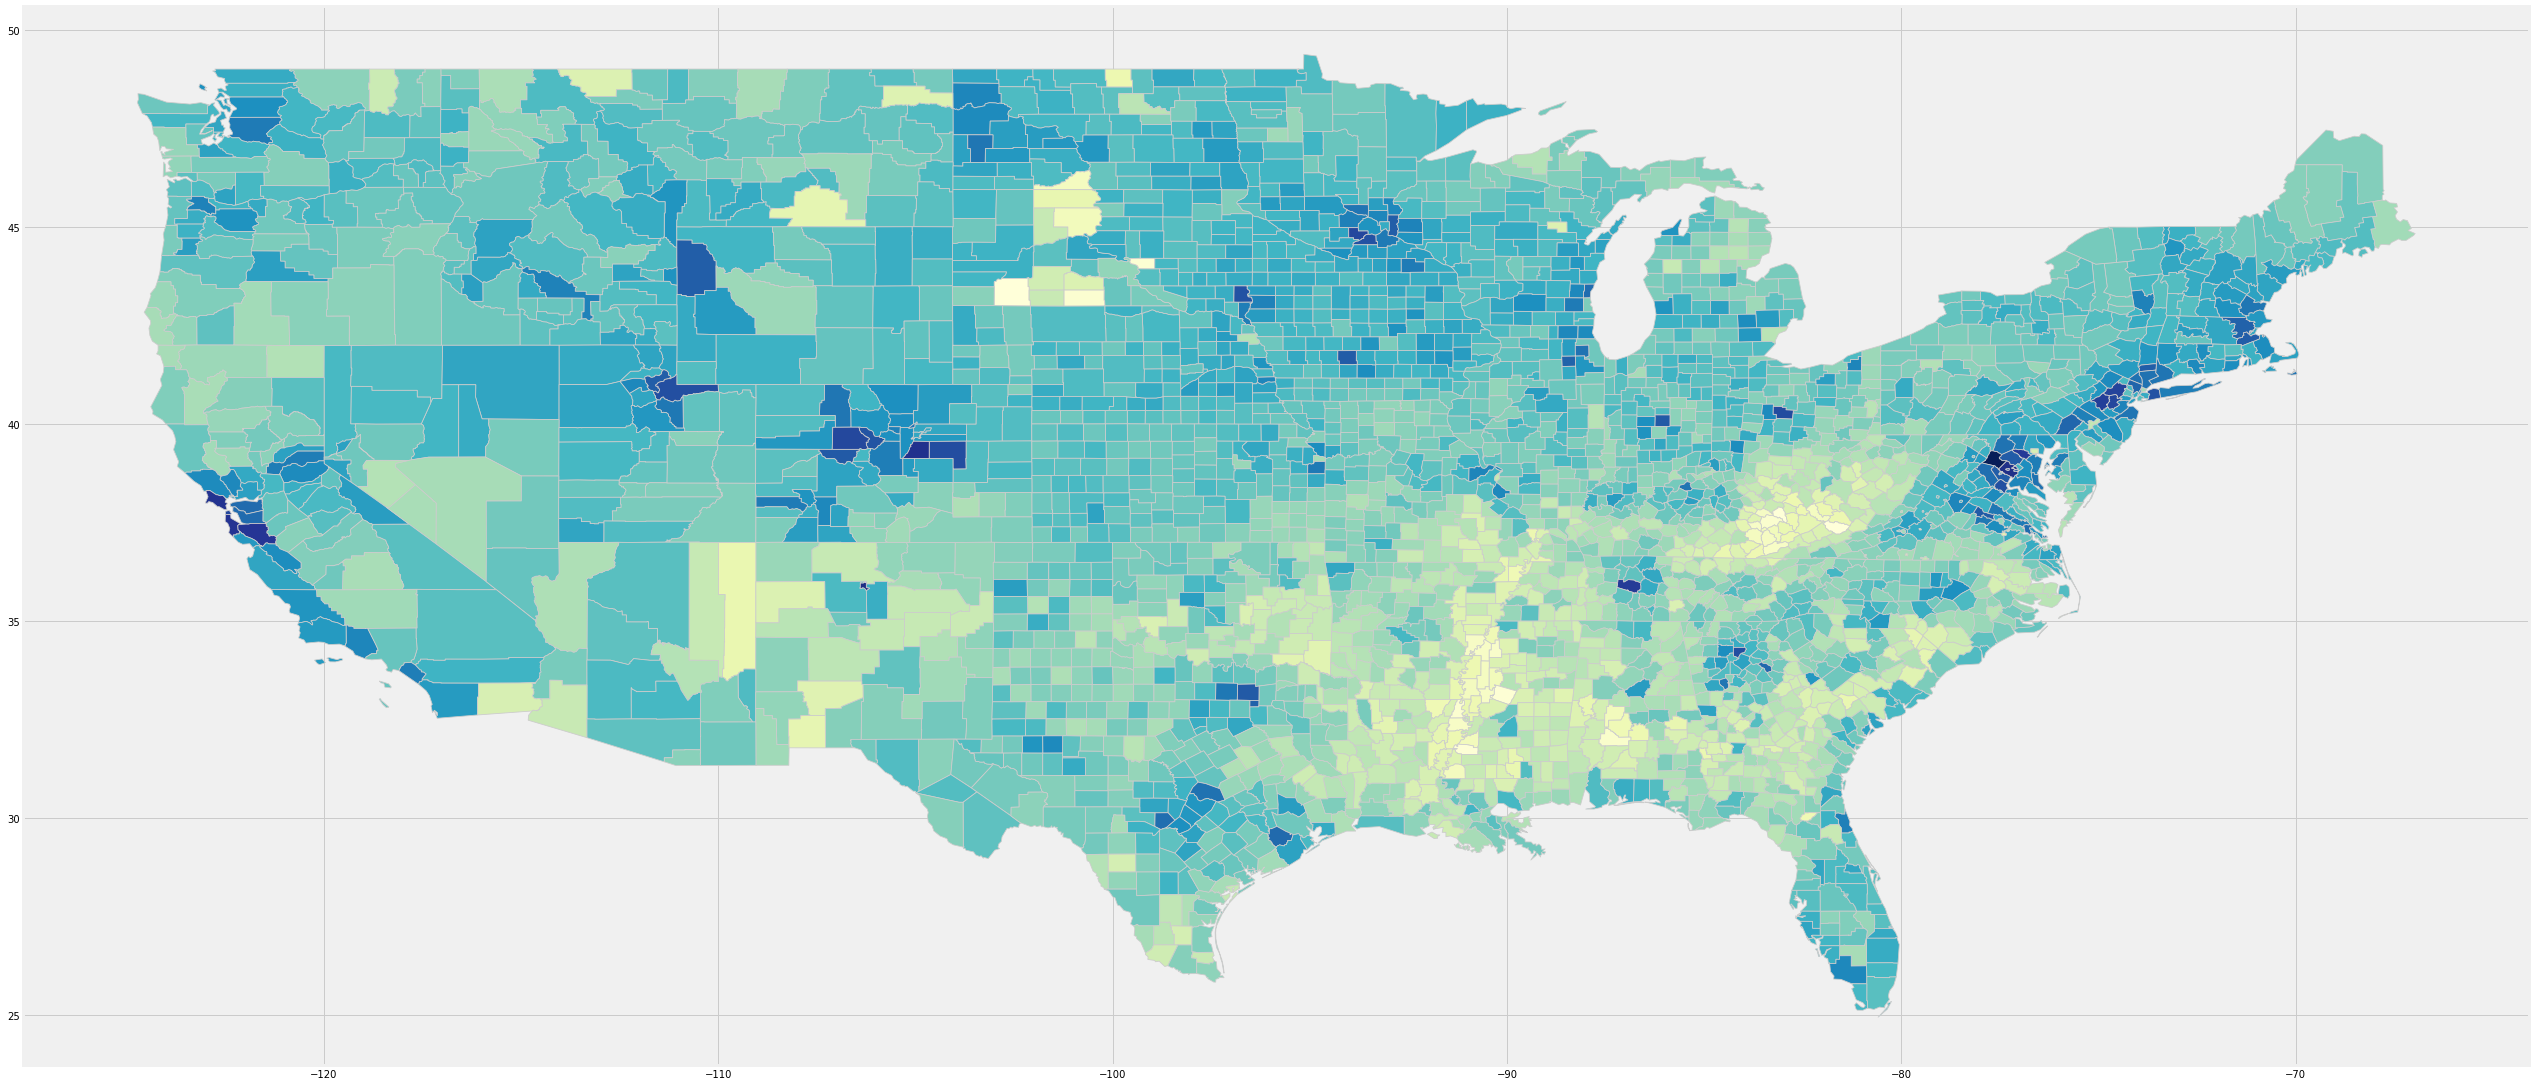

In [132]:
# set the range for the choropleth
vmin, vmax = 120, 220
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(40, 40))
counties_map_df.plot(column='Predicted Happiness', cmap='YlGnBu', linewidth=0.8, ax=ax, edgecolor = '0.8' )